# Предсказание   дохода



Целью данной задачи является построение модели **классификации пользователей**: 

на вход модель будет принимать данные о человеке, 

а на выходе она должна предсказывать бинарный уровень дохода человека (больше или меньше 50000$ за год).

## Загрузка библиотек

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

In [47]:
#!pip install comet_ml

In [48]:
from comet_ml import Experiment

In [49]:
#@title CometML set up
project_name = 'predict-income'
workspace = 'ketrint'
api_key = ''

In [50]:
experiment = Experiment(project_name=project_name, workspace=workspace, api_key=api_key, log_code=True)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key  is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/python-sdk/warnings-errors/
COMET ERROR: The given API key  is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/python-sdk/warnings-errors/


## Загрузка данных

In [51]:
%%capture
!wget https://www.dropbox.com/s/1hfrcm09qtvoeoz/train.csv
!wget https://www.dropbox.com/s/jj7c8r0x57zda0a/test.csv

In [52]:
# Данные изначально разделены на тренировочную и тестовую выборки
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [53]:
train_data

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,49,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
1,27,NaN,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,45,United-States,0
2,44,NaN,11th,Married-civ-spouse,Other-service,Husband,Black,Male,0.0,0.0,60,United-States,0
3,59,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,0.0,0.0,60,United-States,0
4,54,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,0.0,1408.0,38,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24415,47,Private,Bachelors,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40,United-States,0
24416,31,Private,12th,Divorced,Other-service,Unmarried,White,Female,0.0,0.0,21,United-States,0
24417,18,Private,11th,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,20,United-States,0
24418,50,Self-emp-not-inc,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,84,United-States,0


In [54]:
test_data

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,27,Private,Some-college,Divorced,Adm-clerical,Not-in-family,White,Female,0.0,0.0,38,United-States,0
1,45,State-gov,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40,United-States,0
2,29,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,NaN,55,United-States,1
3,30,Private,Bachelors,Never-married,Machine-op-inspct,Not-in-family,White,Female,0.0,0.0,40,United-States,0
4,29,Self-emp-not-inc,Some-college,Divorced,Craft-repair,Not-in-family,White,Male,2202.0,0.0,50,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,35,Private,HS-grad,Separated,Other-service,Not-in-family,Black,Male,0.0,0.0,40,United-States,0
8137,60,Private,5th-6th,Married-civ-spouse,Sales,Husband,White,Male,NaN,0.0,40,?,1
8138,25,?,HS-grad,Never-married,?,Unmarried,Black,Female,0.0,0.0,40,United-States,0
8139,50,Private,Bachelors,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40,United-States,1


Вижу в данных пропуски, которые закодированы через ?. Надо их перевести в NaN

In [55]:
# train_data.replace(r'^\?$', np.NaN, regex=True, inplace=True)
# test_data.replace(r'^\?$', np.NaN, regex=True, inplace=True)

In [56]:
zero_on_train = train_data.isnull().sum()
zero_on_train[zero_on_train > 0]

workclass       1197
education        977
capital-gain     715
capital-loss     484
dtype: int64

In [57]:
zero_on_test = test_data.isnull().sum()
zero_on_test[zero_on_test > 0]

workclass       431
education       325
capital-gain    262
capital-loss    167
dtype: int64

Проверим размерности наших файлов:

In [58]:
train_data.shape, test_data.shape

((24420, 13), (8141, 13))

**Работаем с целевой переменной**



In [59]:
TARGET = 'income'

In [60]:
X_train, y_train = train_data.drop(columns=[TARGET]), train_data[TARGET]
X_test, y_test = test_data.drop(columns=[TARGET]), test_data[TARGET]

**Оценка сбалансированности выборки**

In [61]:
y_train.value_counts(normalize=True)

income
0    0.757821
1    0.242179
Name: proportion, dtype: float64

In [62]:
y_test.value_counts(normalize=True)

income
0    0.763297
1    0.236703
Name: proportion, dtype: float64

Таким образом, имеем задачу **несбалансированной бинарной классификации**.

Но при этом видно, что датасет на выборки был разделен со стратификацией, доли целевых классов сохранены.

## Общая статистика по числовым данным



In [63]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


In [64]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
age,8141.0,38.532244,13.647073,17.0,27.0,37.0,48.0,90.0
capital-gain,7879.0,1177.948471,8059.229616,0.0,0.0,0.0,0.0,99999.0
capital-loss,7974.0,82.083647,394.114726,0.0,0.0,0.0,0.0,4356.0
hours-per-week,8141.0,40.590099,12.489254,1.0,40.0,40.0,45.0,99.0


Статистики и распределения очень похожи на обоих выборках

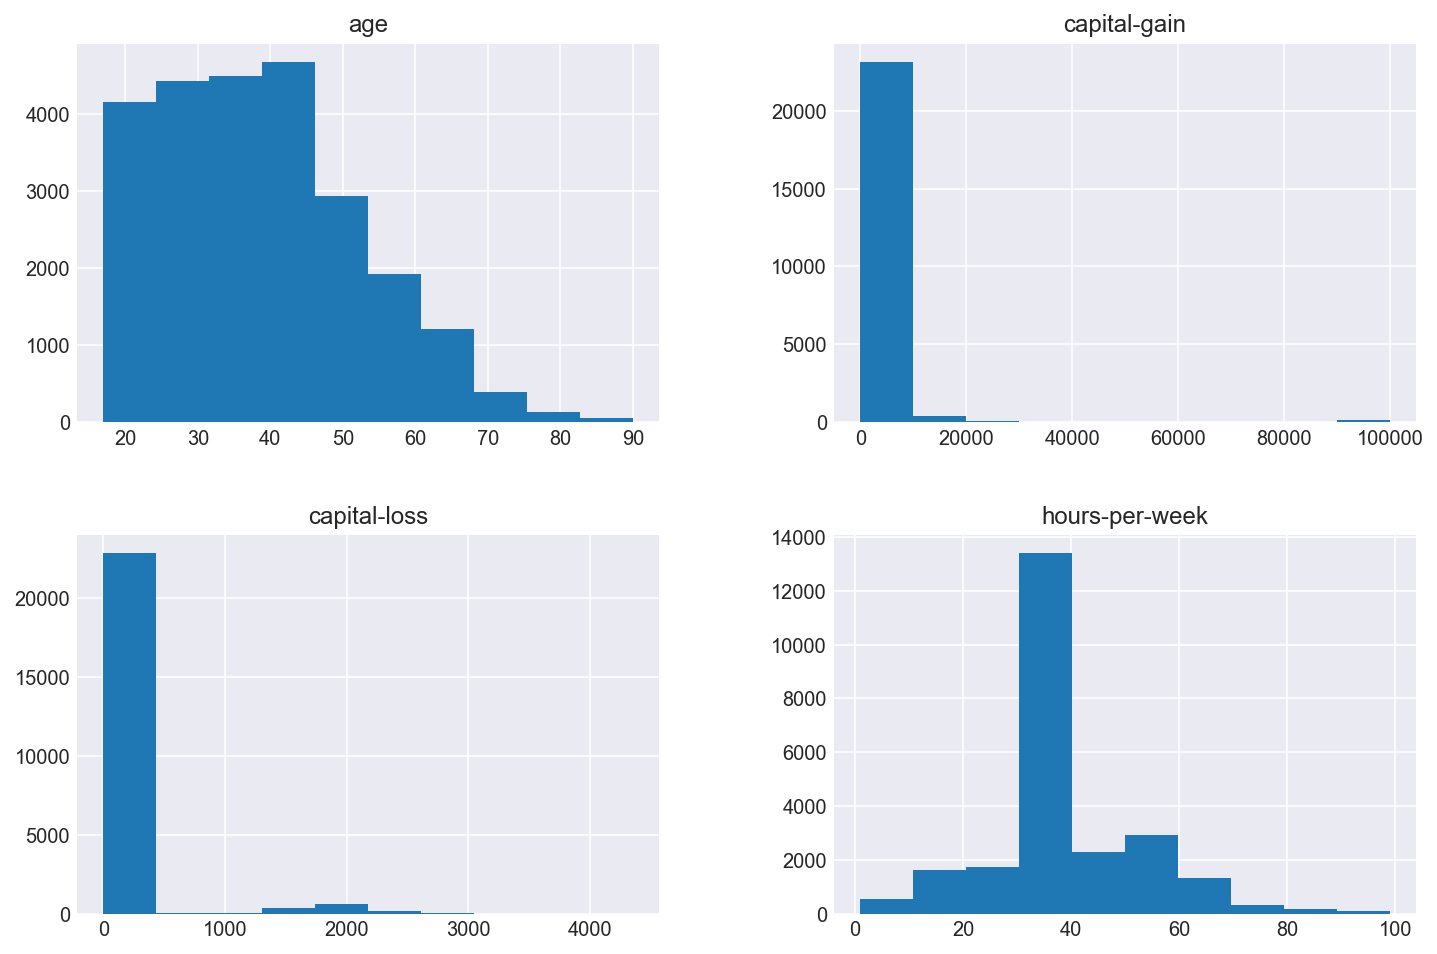

In [65]:
X_train.hist(figsize=(12,8));
# experiment.log_figure('X_train_numeric_distr', plt)

Что мы можем увидеть из результатов?
* Числовых переменных в исходных данных только 4;
* Возраст пользователя варьируется в диапазоне от 17 до 90 лет и в среднем составляет 39 лет;
* Видим пропуски в признаках capital-gain и capital-loss (значение count меньше размера данных). По гистограмме можно заметить, что большое количество значений в этих признаках - это просто нули;

## Предобработка данных

### Проверка на наличие пропусков и типов переменных



In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


Типы в наших данных:
* 8 признаков типа **object** - обычно это строковые значения;
* 3 признака типа **int64** - целочисленные значения;
* 2 признака типа **float64** - числа с плавающей запятой. 

Кроме этого, мы видим, что признаки *workclass, education, capital-gain и capital-loss* имеют пропуски в данных.

### Обработка пропусков в данных

Далеко не все алгоритмы умеют работать с пропусками в данных. Кроме этого, удачно заполнив пропуски, мы сможем лучше восстановить распределение данных, а значит лучше построить моделей. 

Самые популярные методы для обработки пропусков:
- Удаление значений с пропусками (не желательно при большом количестве пропусков, потому что теряются данные);
- Заполнение средним/медианным значением;
- Заполненние самым частым значением;
- Заполнение случайным значением.

**Важно:** тестовую выборку мы всегда обрабатываем также, как и обучающую выборку. 

In [67]:
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)

Сделаем то же самое для тестовой выборки:

In [68]:
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)
X_test['capital-gain'] = X_test['capital-gain'].fillna(0)

In [69]:
X_train['workclass'].value_counts(True).head(1)

workclass
Private    0.696766
Name: proportion, dtype: float64

In [70]:
X_train['education'].value_counts(True).head(1)

education
HS-grad    0.322484
Name: proportion, dtype: float64

In [71]:
# X_train[TARGET] = y_train

In [72]:
# X_train.groupby(['income', 'workclass'])['workclass'].count()

Заполнение пропусков можно провести в разрезе целевого признака

In [73]:
# X_train.groupby(['income', 'education'])['education'].count()

Наиболее частое значение признака **workclass** - Private, признака **education** - HS-grad. 

Теперь явно заполним пропуски:

In [74]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

Сделаем то же самое для тестовой выборки:

In [75]:
X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

### Кодировка категориальных переменных

В данных 8 столбцов являются категориальными признаками. При чём в нашей задаче эти признаки **текстовые**. Машине сложно обрабатывать текстовые признаки, поэтому нам необходимо закодировать их, то есть преобразовать в числовые. 

Для начала необходимо выделить категорильные признаки:

In [76]:
categorical_features = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race', 'sex',
                        'native-country']

non_categorical_features = ['age', 'capital-gain', 'capital-loss',
                            'hours-per-week']

In [77]:
for cat_col in categorical_features:
    print(round(X_train[cat_col].value_counts(True) * 100, 2))
    print('-' * 20)

workclass
Private             71.16
Self-emp-not-inc     7.38
Local-gov            6.21
?                    5.25
State-gov            3.84
Self-emp-inc         3.32
Federal-gov          2.77
Without-pay          0.04
Never-worked         0.03
Name: proportion, dtype: float64
--------------------
education
HS-grad         34.96
Some-college    21.42
Bachelors       15.89
Masters          5.04
Assoc-voc        4.11
11th             3.51
Assoc-acdm       3.16
10th             2.74
7th-8th          1.84
Prof-school      1.70
9th              1.49
12th             1.25
Doctorate        1.24
5th-6th          0.96
1st-4th          0.54
Preschool        0.15
Name: proportion, dtype: float64
--------------------
marital-status
Married-civ-spouse       46.26
Never-married            32.74
Divorced                 13.58
Separated                 3.11
Widowed                   2.99
Married-spouse-absent     1.24
Married-AF-spouse         0.08
Name: proportion, dtype: float64
--------------------


Посмотрим на столбцы категориальных переменных:

In [78]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


Мы рассмотрим два популярных метода кодирования категориальных признаков:
* Label Encoding, которому соответствует класс `LabelEncoder()` из библиотеки **sklearn**
* One Hot Encoding, которому соответствует класс `OneHotEncoder()` из библиотеки **sklearn**

**Label Encoding**
Вообще-то этот обработчик нужен для разметки целевого категориального признака, когда он не бинарный.
Удобно этим обработчиком расставить числовые метки.

Использование же его для кодировки категориальных признаков приводит к тому, что мы фактически случайным образом назначаем веса классам в признаках. Он начинает работать как OdrinaryEncoder, но без явного указания весов.

Глупость какая-то!

In [79]:
from sklearn.preprocessing import LabelEncoder

In [80]:
label_encoder = LabelEncoder()

In [81]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

In [82]:
# из-за того что подход некорректный, пришлось использовать цикл что бы обработать каждый признак
# ведь этот обработчик принимает лишь вектор меток y, а не матрицу признаков
for feature in categorical_features:
    X_train_le[feature] = label_encoder.fit_transform(X_train_le[feature])
    X_test_le[feature] = label_encoder.transform(X_test_le[feature])

In [83]:
X_train_le

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39
...,...,...,...,...,...,...,...,...,...,...,...,...
24415,47,4,9,2,3,0,4,1,0.0,0.0,40,39
24416,31,4,2,0,8,4,4,0,0.0,0.0,21,39
24417,18,4,1,4,1,3,4,0,0.0,0.0,20,39
24418,50,6,11,2,5,0,4,1,0.0,0.0,84,39


**One Hot Encoding**



In [89]:
from category_encoders import OneHotEncoder

onehot_encoder = OneHotEncoder(categorical_features)

X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()

X_train_ohe = onehot_encoder.fit_transform(X_train_ohe)
X_test_ohe = onehot_encoder.transform(X_test_ohe)

## Обучение модели 

## Выбор метода обучения классификатора

Для обучения классификатора воспользуемся логистической регрессией.
 

In [ ]:
from sklearn.linear_model import LogisticRegression

Создаем прототип класса модели:

In [ ]:
linear_model = LogisticRegression()

## Обучение модели на разных типах закодированных данных

In [ ]:
linear_model_oh.fit(X_train_new, y_train)

In [ ]:
linear_model.fit(X_train_le, y_train)

# Валидация модели на тестовой выборке

In [ ]:
prediction_oh = linear_model_oh.predict(X_test_new)

In [ ]:
np.unique(prediction_oh)

array([0, 1])

In [ ]:
# Сколько 1го класса присутсвует в предсказаниях?

In [ ]:
# Сколько 1го класса присутсвует в y_test?

## Точность предсказания

Посчитаем точность (**accuracy**) работы моделей. Напомним, что точность отражает, сколько в процентном соотношении от размера тестовой выборки модель угадала 1 и сколько угадала 0.

Функция для подсчета точности реализована в библиотеке **sklearn** и называется `accuracy_score()`.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc_oh = accuracy_score(y_test, prediction_oh)

In [ ]:
experiment.log_metric('Accuracy OneHot data', acc_oh)

Сравним значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0. Для этого можно в функцию `accuracy_score()` в качестве второго аргумента передать массив нулей такого же размера. Это делается с помощью функции `zeros_like()` из библиотеки **numpy**.

In [ ]:
print('Accuracy Major Class: ', accuracy_score(y_test, np.zeros_like(y_test)).round(3))

Accuracy Major Class:  0.763


In [ ]:
# Залогировать accuracy для LE

## Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности. 


|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         | 


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pd.DataFrame(confusion_matrix(y_test, prediction_oh))

,0,1
0,5881,333
1,663,1264


In [ ]:
experiment.log_confusion_matrix(y_test, prediction_oh)

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=811d139ac16c496ca18bedce9acaff29&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8',
 'assetId': '811d139ac16c496ca18bedce9acaff29',
 'web': 'https://www.comet.ml/api/asset/download?assetId=811d139ac16c496ca18bedce9acaff29&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8'}

## Прогноз вероятности принадлежности к классу

In [ ]:
pred_proba_oh = linear_model_oh.predict_proba(X_test_new)

In [ ]:
# Как выглядят предсказания?

array([[0.9907915 , 0.00920851],
       [0.3954633 , 0.6045367 ],
       [0.2793576 , 0.7206424 ],
       [0.9758066 , 0.02419338],
       [0.9899469 , 0.01005312]], dtype=float32)

In [ ]:
pred_proba = pred_proba_oh[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дохода > 50к, метки `1`.

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=60a2196ca6634687bd348a2da76c5b98&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8',
 'imageId': '60a2196ca6634687bd348a2da76c5b98',
 'web': 'https://www.comet.ml/api/image/download?imageId=60a2196ca6634687bd348a2da76c5b98&experimentKey=debe4b2a28e249a9bcf70e20c2c256b8'}

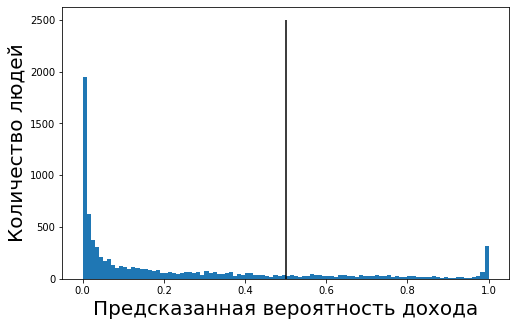

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(pred_proba, bins=100)
plt.vlines(0.5, 0, 2500)

plt.xlabel('Предсказанная вероятность дохода', fontsize=20)
plt.ylabel('Количество людей', fontsize=20)

experiment.log_figure('predicted_income_probability', plt)

##ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$. 

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция `roc_curve()` из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога `threshold`, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции `roc_curve()` необходимо передать два аргумента:
* истинные значения меток
* вероятности, предсказанные моделью

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, pred_proba)

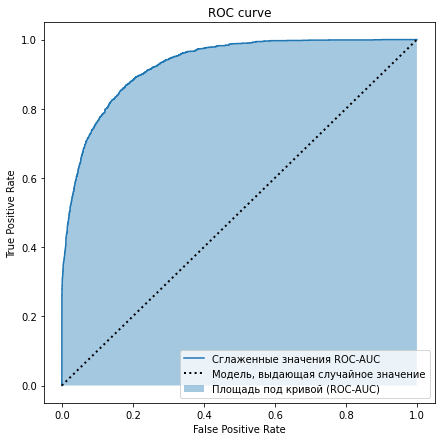

In [ ]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, 
         label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="pre", 
                 alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)

In [ ]:
print("ROC-AUC на тестовой выборке:", roc_auc_score(y_test, pred_proba).round(3)) 

ROC-AUC на тестовой выборке: 0.928


In [ ]:
experiment.log_metric('roc_auc OneHot data', roc_auc)

In [ ]:
pred_proba_le = linear_model.predict_proba(X_test_new)

In [ ]:
pred_proba = pred_proba_le[:, 1]

In [ ]:
roc_auc = roc_auc_score(y_test, pred_proba).round(3)
roc_auc